In [6]:
import sys
sys.path.insert(0, '../../../pyLDLE2/')
sys.path.insert(0, '../src/')

import numpy as np
import networkx as nx
import ConnectionNetworkX as cnx

from matplotlib import pyplot as plt
from matplotlib import cm

from pyLDLE2 import datasets, visualize_, util_

In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/nbks/../src/ConnectionNetworkX.py'>

In [27]:
def draw3d(G, pos, node_color, node_size, edge_color, edge_width=1, figsize=(8,4)):
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, c=node_color, s=node_size, ec="w")

    # Plot the edges
    for i in range(edge_xyz.shape[0]):
        vizedge = edge_xyz[i,:]
        direction = [vizedge[1,0]-vizedge[0,0],
                     vizedge[1,1]-vizedge[0,1],
                     vizedge[1,2]-vizedge[0,2]]
        direction = np.array(direction)
        edge_length = np.linalg.norm(direction)
        direction = direction/edge_length
        ax.quiver(vizedge[0,0], vizedge[0,1], vizedge[0,2],
                  direction[0], direction[1], direction[2],
                  length=edge_length, color=edge_color[i])
        #ax.plot(*vizedge.T, color=edge_color[i], linewidth=edge_width)

    visualize_.set_axes_equal(ax)
    ax.set_xlim(np.min(node_xyz[:,0]), np.max(node_xyz[:,0]))
    ax.set_ylim(np.min(node_xyz[:,1]), np.max(node_xyz[:,1]))
    ax.set_zlim(np.min(node_xyz[:,2]), np.max(node_xyz[:,2]))
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.margins(0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Load data

In [4]:
X, labelsMat, _ = datasets.Datasets().sphere(n=2000)

X.shape =  (2000, 3)


In [7]:
s_d_e, pred = util_.shortest_paths(X, 10)

<IPython.core.display.Javascript object>


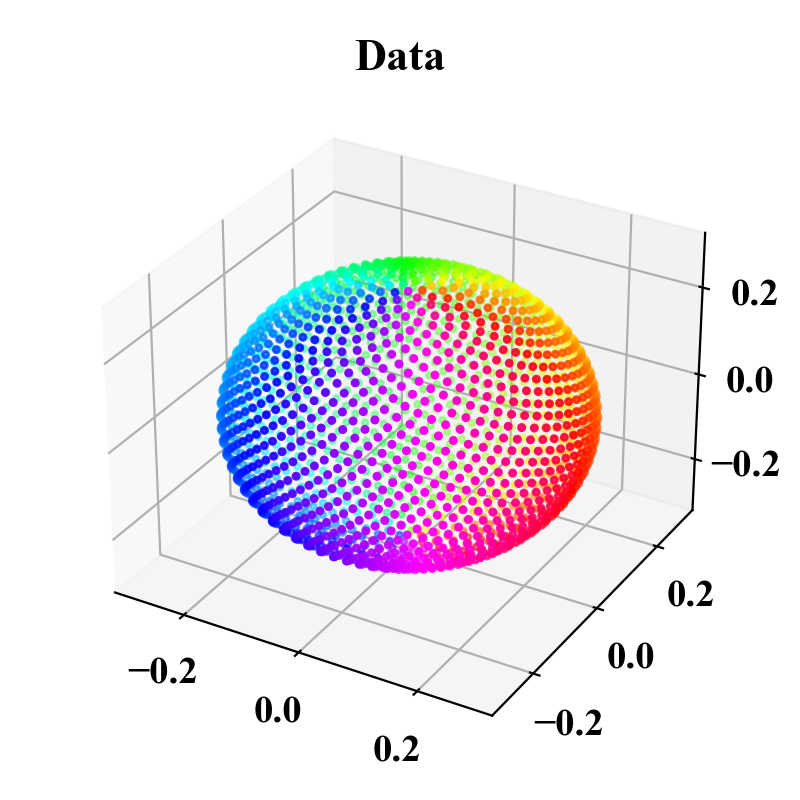

In [8]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

# Set source and destination nodes

In [9]:
source = 0
dest1 = 1597
dest2 = 1561

<IPython.core.display.Javascript object>


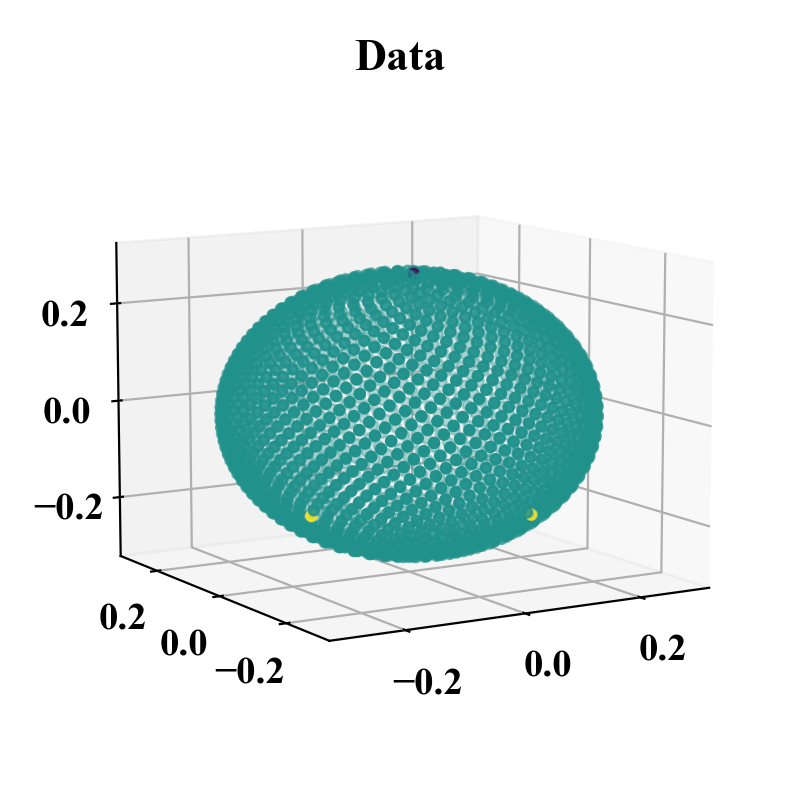

In [10]:
%matplotlib notebook
vis = visualize_.Visualize()
labels = np.zeros(X.shape[0])
labels[source] = -1
labels[dest1] = 1
labels[dest2] = 1
vis.data(X, labels, cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)

#  Build connection graph

In [11]:
eps_pca = 0.05
eps = eps_pca
d = 2
CG = cnx.cnxFromData(X, eps_pca, eps, d=d, tol=0.2, kernel='linear', triv_sigma=False)

Total edges before removal: 15550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2175.28it/s]


Proportion of edges which were removed due to remoteness:  0.003472668810289389


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:27<00:00, 22.97it/s]


# Set B, w, mu, nu, c

In [12]:
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
w = np.array(list(nx.get_edge_attributes(CG, 'weight').values()))

sigma1 = 0.1
sigma2 = 0.1
mu = np.zeros((n, d))
mu[:,0] = np.exp(-s_d_e[source,:]**2/sigma1**2)
mu[:,1] = np.exp(-s_d_e[source,:]**2/sigma2**2)
mu = mu/np.sum(mu, axis=0)[None,:]
mu = mu.flatten()

nu = np.zeros((n, d))
nu[:,0] = np.exp(-s_d_e[dest1,:]**2/sigma1**2)
nu[:,1] = np.exp(-s_d_e[dest2,:]**2/sigma2**2)
nu = nu/np.sum(nu, axis=0)[None,:]
nu = nu.flatten()

c = (mu - nu)

# Plot c

<IPython.core.display.Javascript object>


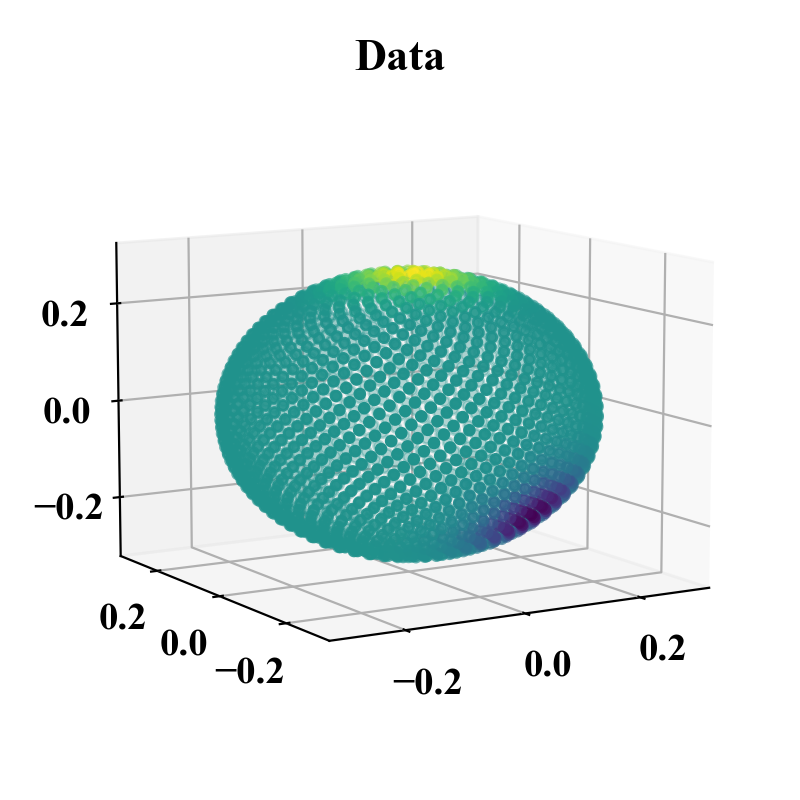

<IPython.core.display.Javascript object>


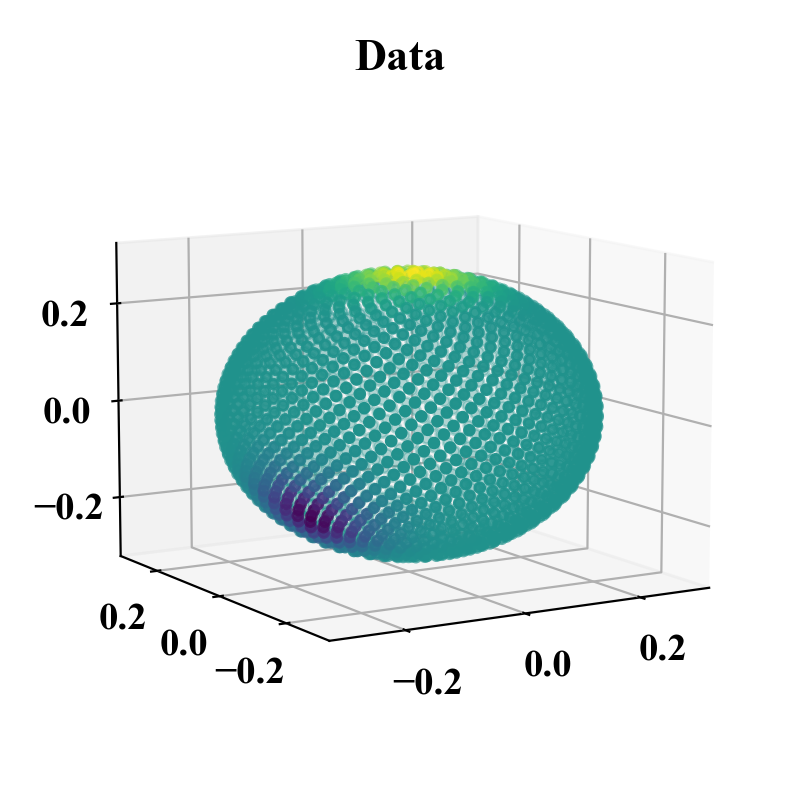

In [13]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, c.reshape((n,d))[:,0], cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)
vis.data(X, c.reshape((n,d))[:,1], cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)

# Check feasibility of primal i.e. $B^TJ = c$

In [14]:
temp_J, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c, rcond=None)
print('Error is:', np.linalg.norm(c.flatten() - B.T.dot(temp_J).flatten())) # if this is small then feasible

Error is: 1.7972371411886096e-15


In [15]:
np.max(w)

0.04999941329736893

# Solve Beckmann dual using gradient descent

In [16]:
learning_rate = 0.01
alpha = np.max(w)*50
n_epochs = 5000

phi, phi0 = cnx.optimize_(B, w, c, learning_rate=learning_rate, alpha=alpha,
                    n_epochs=n_epochs, phi0='least_squares')

Initial loss: (tensor(-0.5999), tensor(0.0011))
epoch: 0, loss: -0.599677, loss0: -0.599903, loss1: 0.001133
epoch: 10, loss: -0.965095, loss0: -0.993749, loss1: 0.143270
epoch: 20, loss: -1.200112, loss0: -1.294562, loss1: 0.472242
epoch: 30, loss: -1.417030, loss0: -1.513318, loss1: 0.481435
epoch: 40, loss: -1.613567, loss0: -1.723885, loss1: 0.551586
epoch: 50, loss: -1.791705, loss0: -1.934423, loss1: 0.713585
epoch: 60, loss: -1.949574, loss0: -2.132723, loss1: 0.915735
epoch: 70, loss: -2.087501, loss0: -2.314959, loss1: 1.137281
epoch: 80, loss: -2.206405, loss0: -2.484193, loss1: 1.388921
epoch: 90, loss: -2.307825, loss0: -2.639149, loss1: 1.656601
epoch: 100, loss: -2.392990, loss0: -2.779282, loss1: 1.931436
epoch: 110, loss: -2.463502, loss0: -2.906024, loss1: 2.212584
epoch: 120, loss: -2.521262, loss0: -3.020207, loss1: 2.494695
epoch: 130, loss: -2.567921, loss0: -3.122034, loss1: 2.770533
epoch: 140, loss: -2.604825, loss0: -3.212156, loss1: 3.036616
epoch: 150, loss: 

epoch: 1290, loss: -2.708985, loss0: -3.726028, loss1: 5.085155
epoch: 1300, loss: -2.708992, loss0: -3.726015, loss1: 5.085056
epoch: 1310, loss: -2.708994, loss0: -3.726019, loss1: 5.085061
epoch: 1320, loss: -2.708991, loss0: -3.726027, loss1: 5.085121
epoch: 1330, loss: -2.708995, loss0: -3.726025, loss1: 5.085089
epoch: 1340, loss: -2.708988, loss0: -3.726020, loss1: 5.085099
epoch: 1350, loss: -2.708992, loss0: -3.726021, loss1: 5.085086
epoch: 1360, loss: -2.708994, loss0: -3.726022, loss1: 5.085077
epoch: 1370, loss: -2.708993, loss0: -3.726019, loss1: 5.085070
epoch: 1380, loss: -2.708991, loss0: -3.726021, loss1: 5.085087
epoch: 1390, loss: -2.708995, loss0: -3.726024, loss1: 5.085088
epoch: 1400, loss: -2.708994, loss0: -3.726023, loss1: 5.085087
epoch: 1410, loss: -2.708994, loss0: -3.726026, loss1: 5.085101
epoch: 1420, loss: -2.708992, loss0: -3.726027, loss1: 5.085113
epoch: 1430, loss: -2.708993, loss0: -3.726024, loss1: 5.085097
epoch: 1440, loss: -2.708989, loss0: -3.

epoch: 2590, loss: -2.708990, loss0: -3.726016, loss1: 5.085071
epoch: 2600, loss: -2.708987, loss0: -3.725990, loss1: 5.084956
epoch: 2610, loss: -2.708987, loss0: -3.725997, loss1: 5.084991
epoch: 2620, loss: -2.708990, loss0: -3.726022, loss1: 5.085097
epoch: 2630, loss: -2.708989, loss0: -3.726020, loss1: 5.085094
epoch: 2640, loss: -2.708989, loss0: -3.726011, loss1: 5.085047
epoch: 2650, loss: -2.708995, loss0: -3.726032, loss1: 5.085125
epoch: 2660, loss: -2.708988, loss0: -3.726027, loss1: 5.085139
epoch: 2670, loss: -2.708987, loss0: -3.726020, loss1: 5.085104
epoch: 2680, loss: -2.708988, loss0: -3.726025, loss1: 5.085128
epoch: 2690, loss: -2.708992, loss0: -3.726022, loss1: 5.085091
epoch: 2700, loss: -2.708996, loss0: -3.726031, loss1: 5.085119
epoch: 2710, loss: -2.708995, loss0: -3.726019, loss1: 5.085061
epoch: 2720, loss: -2.708988, loss0: -3.726026, loss1: 5.085131
epoch: 2730, loss: -2.708986, loss0: -3.726025, loss1: 5.085135
epoch: 2740, loss: -2.708994, loss0: -3.

epoch: 3890, loss: -2.708988, loss0: -3.726022, loss1: 5.085112
epoch: 3900, loss: -2.708991, loss0: -3.726016, loss1: 5.085064
epoch: 3910, loss: -2.708997, loss0: -3.726022, loss1: 5.085070
epoch: 3920, loss: -2.708996, loss0: -3.726030, loss1: 5.085112
epoch: 3930, loss: -2.708982, loss0: -3.726003, loss1: 5.085044
epoch: 3940, loss: -2.708971, loss0: -3.725980, loss1: 5.084984
epoch: 3950, loss: -2.708983, loss0: -3.726010, loss1: 5.085074
epoch: 3960, loss: -2.708986, loss0: -3.726015, loss1: 5.085084
epoch: 3970, loss: -2.708975, loss0: -3.725994, loss1: 5.085037
epoch: 3980, loss: -2.708986, loss0: -3.726010, loss1: 5.085058
epoch: 3990, loss: -2.708989, loss0: -3.726002, loss1: 5.085008
epoch: 4000, loss: -2.708981, loss0: -3.726021, loss1: 5.085144
epoch: 4010, loss: -2.708990, loss0: -3.726003, loss1: 5.085008
epoch: 4020, loss: -2.708993, loss0: -3.726019, loss1: 5.085070
epoch: 4030, loss: -2.708993, loss0: -3.726024, loss1: 5.085093
epoch: 4040, loss: -2.708989, loss0: -3.

# Compute activeness of edges and optimal primal

In [17]:
edge_score = cnx.activenes_of_edges(phi, B, w, c)
J_opt = cnx.optimal_primal(phi, B, w, c, alpha, d) # the mean abs error should be small

mean abs err of sum_{v in V} ||(B^TJ-c)(v)||_1 0.0018929818276715664


In [18]:
J_opt_norm = np.linalg.norm(J_opt, axis=1)

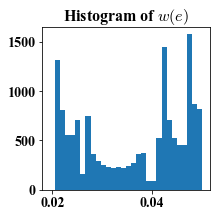

In [19]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(list(nx.get_edge_attributes(CG, "weight").values()), bins=30)
plt.title('Histogram of $w(e)$')
plt.show()

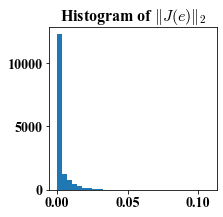

In [20]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt_norm, bins=30)
plt.title('Histogram of $\\left\\|J(e)\\right\\|_2$')
plt.show()

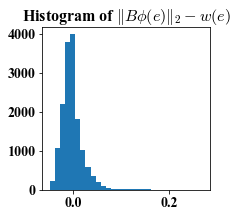

In [21]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score, bins=30)
plt.title('Histogram of $\\left\\|B\\phi(e)\\right\\|_2-w(e)$')
plt.show()

# Plot optimal flow

In [22]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap

to_embed = None # no need to embed if the data is already in <= 3 dimensions, else use isomap/ltsa
embed_dim = None
if to_embed is not None:
    if to_embed == 'isomap':
        fit_obj = Isomap(n_components=embed_dim, n_neighbors=10)
    else:
        fit_obj = LocallyLinearEmbedding(n_components=embed_dim, n_neighbors=10, method='ltsa')
    embedding = fit_obj.fit_transform(X)
else:
    embedding = X

In [24]:
J = J_opt

<IPython.core.display.Javascript object>


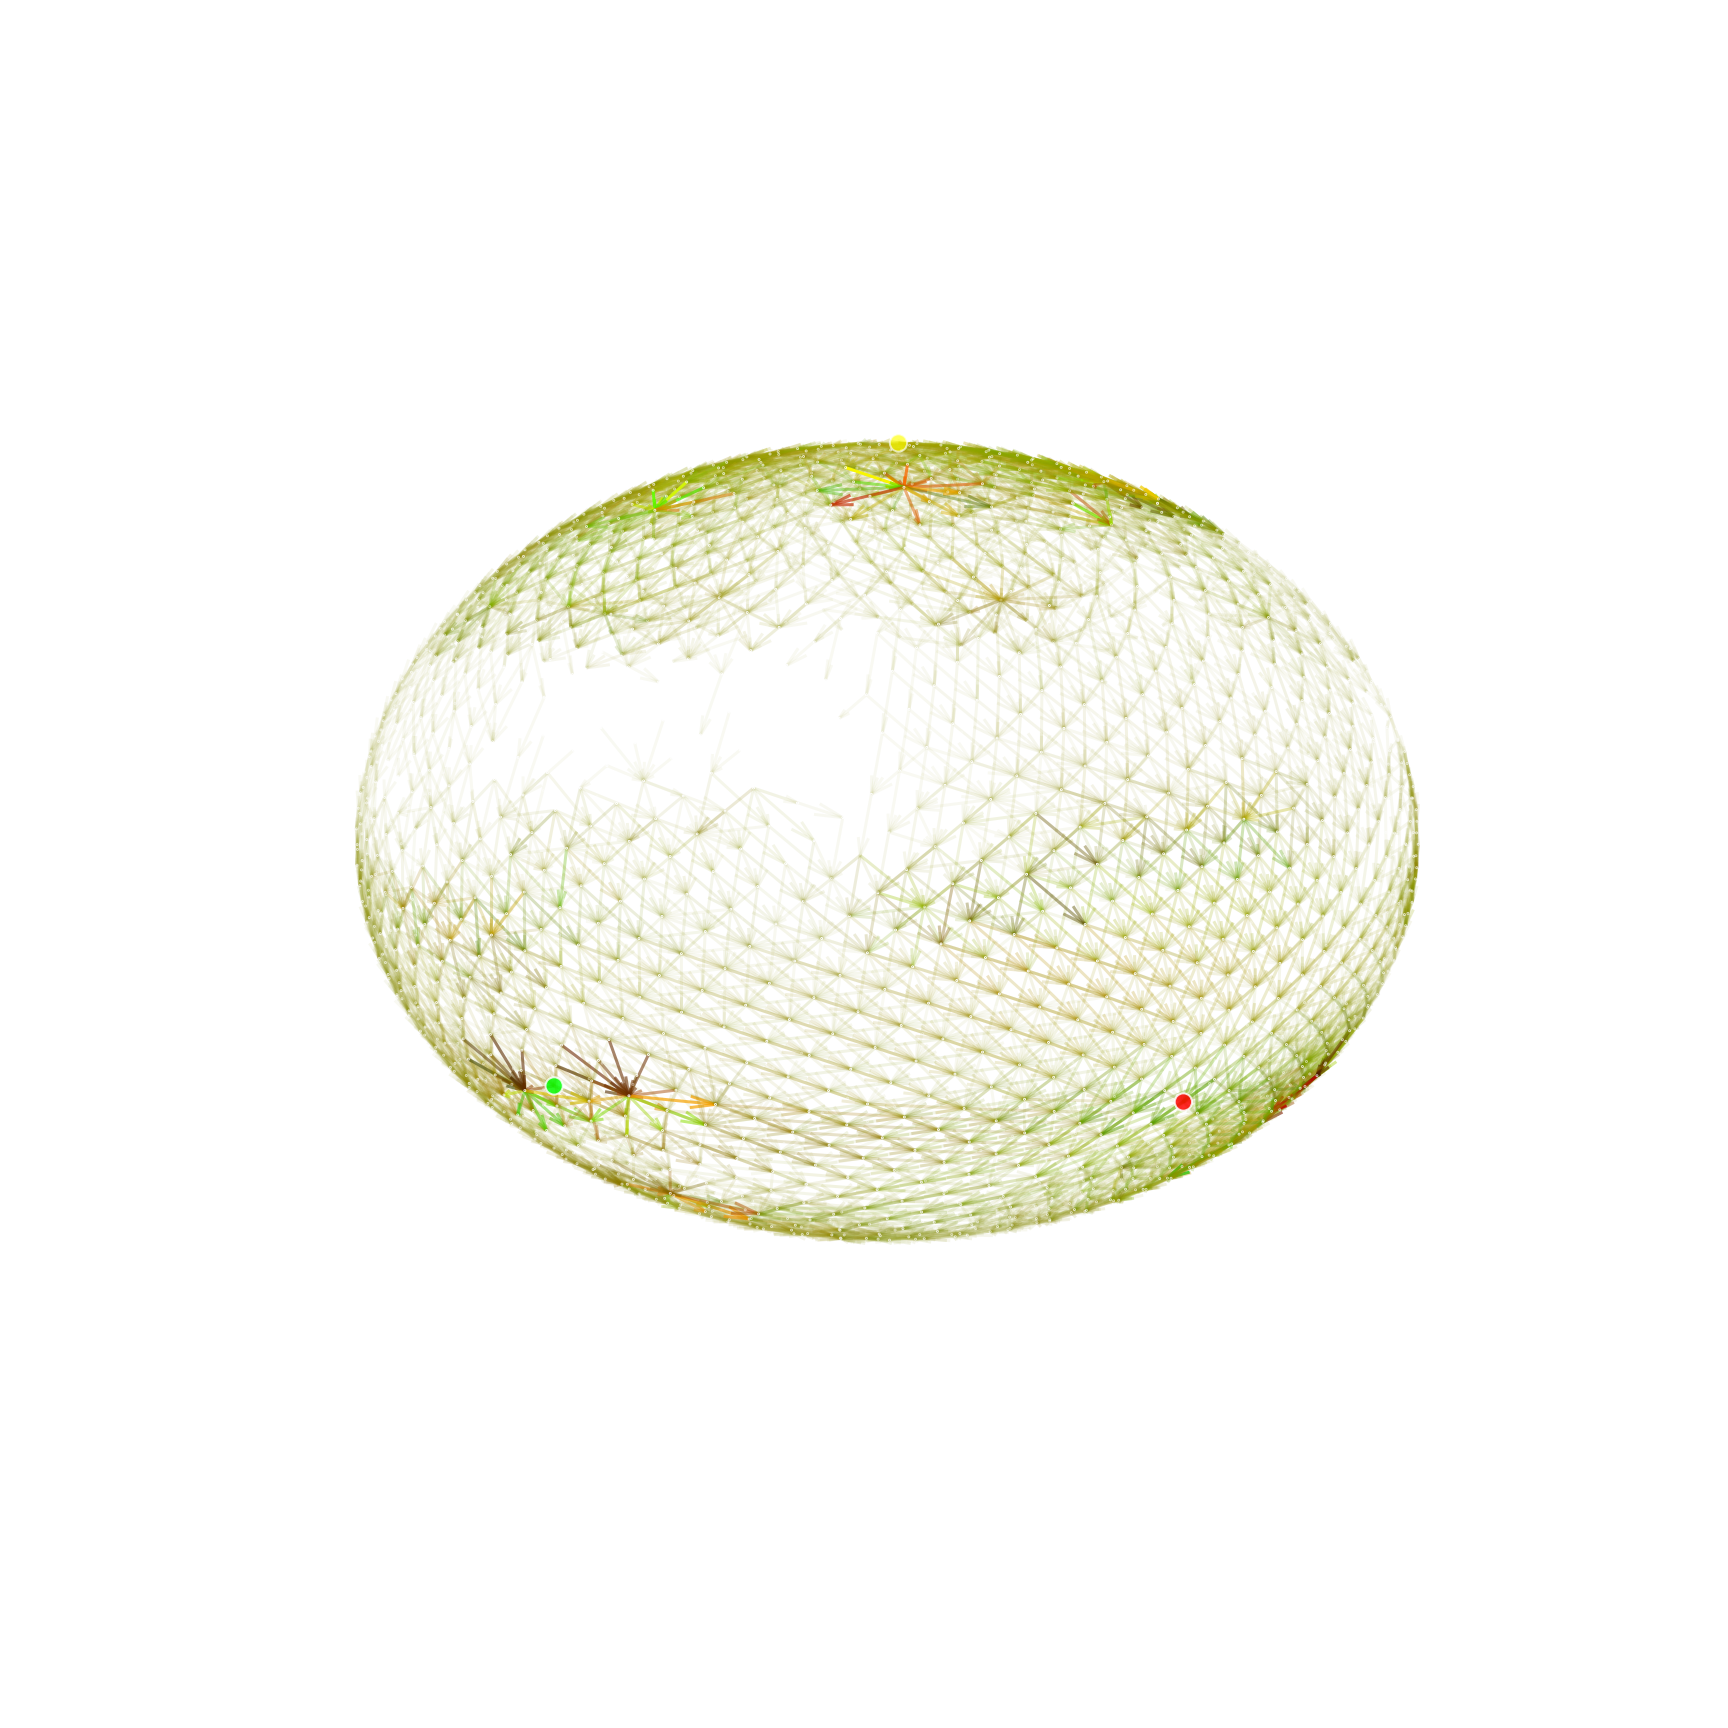

/tmp/ipykernel_80955/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [30]:
%matplotlib notebook

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
edge_color[mask,1] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=0.025, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()

<IPython.core.display.Javascript object>


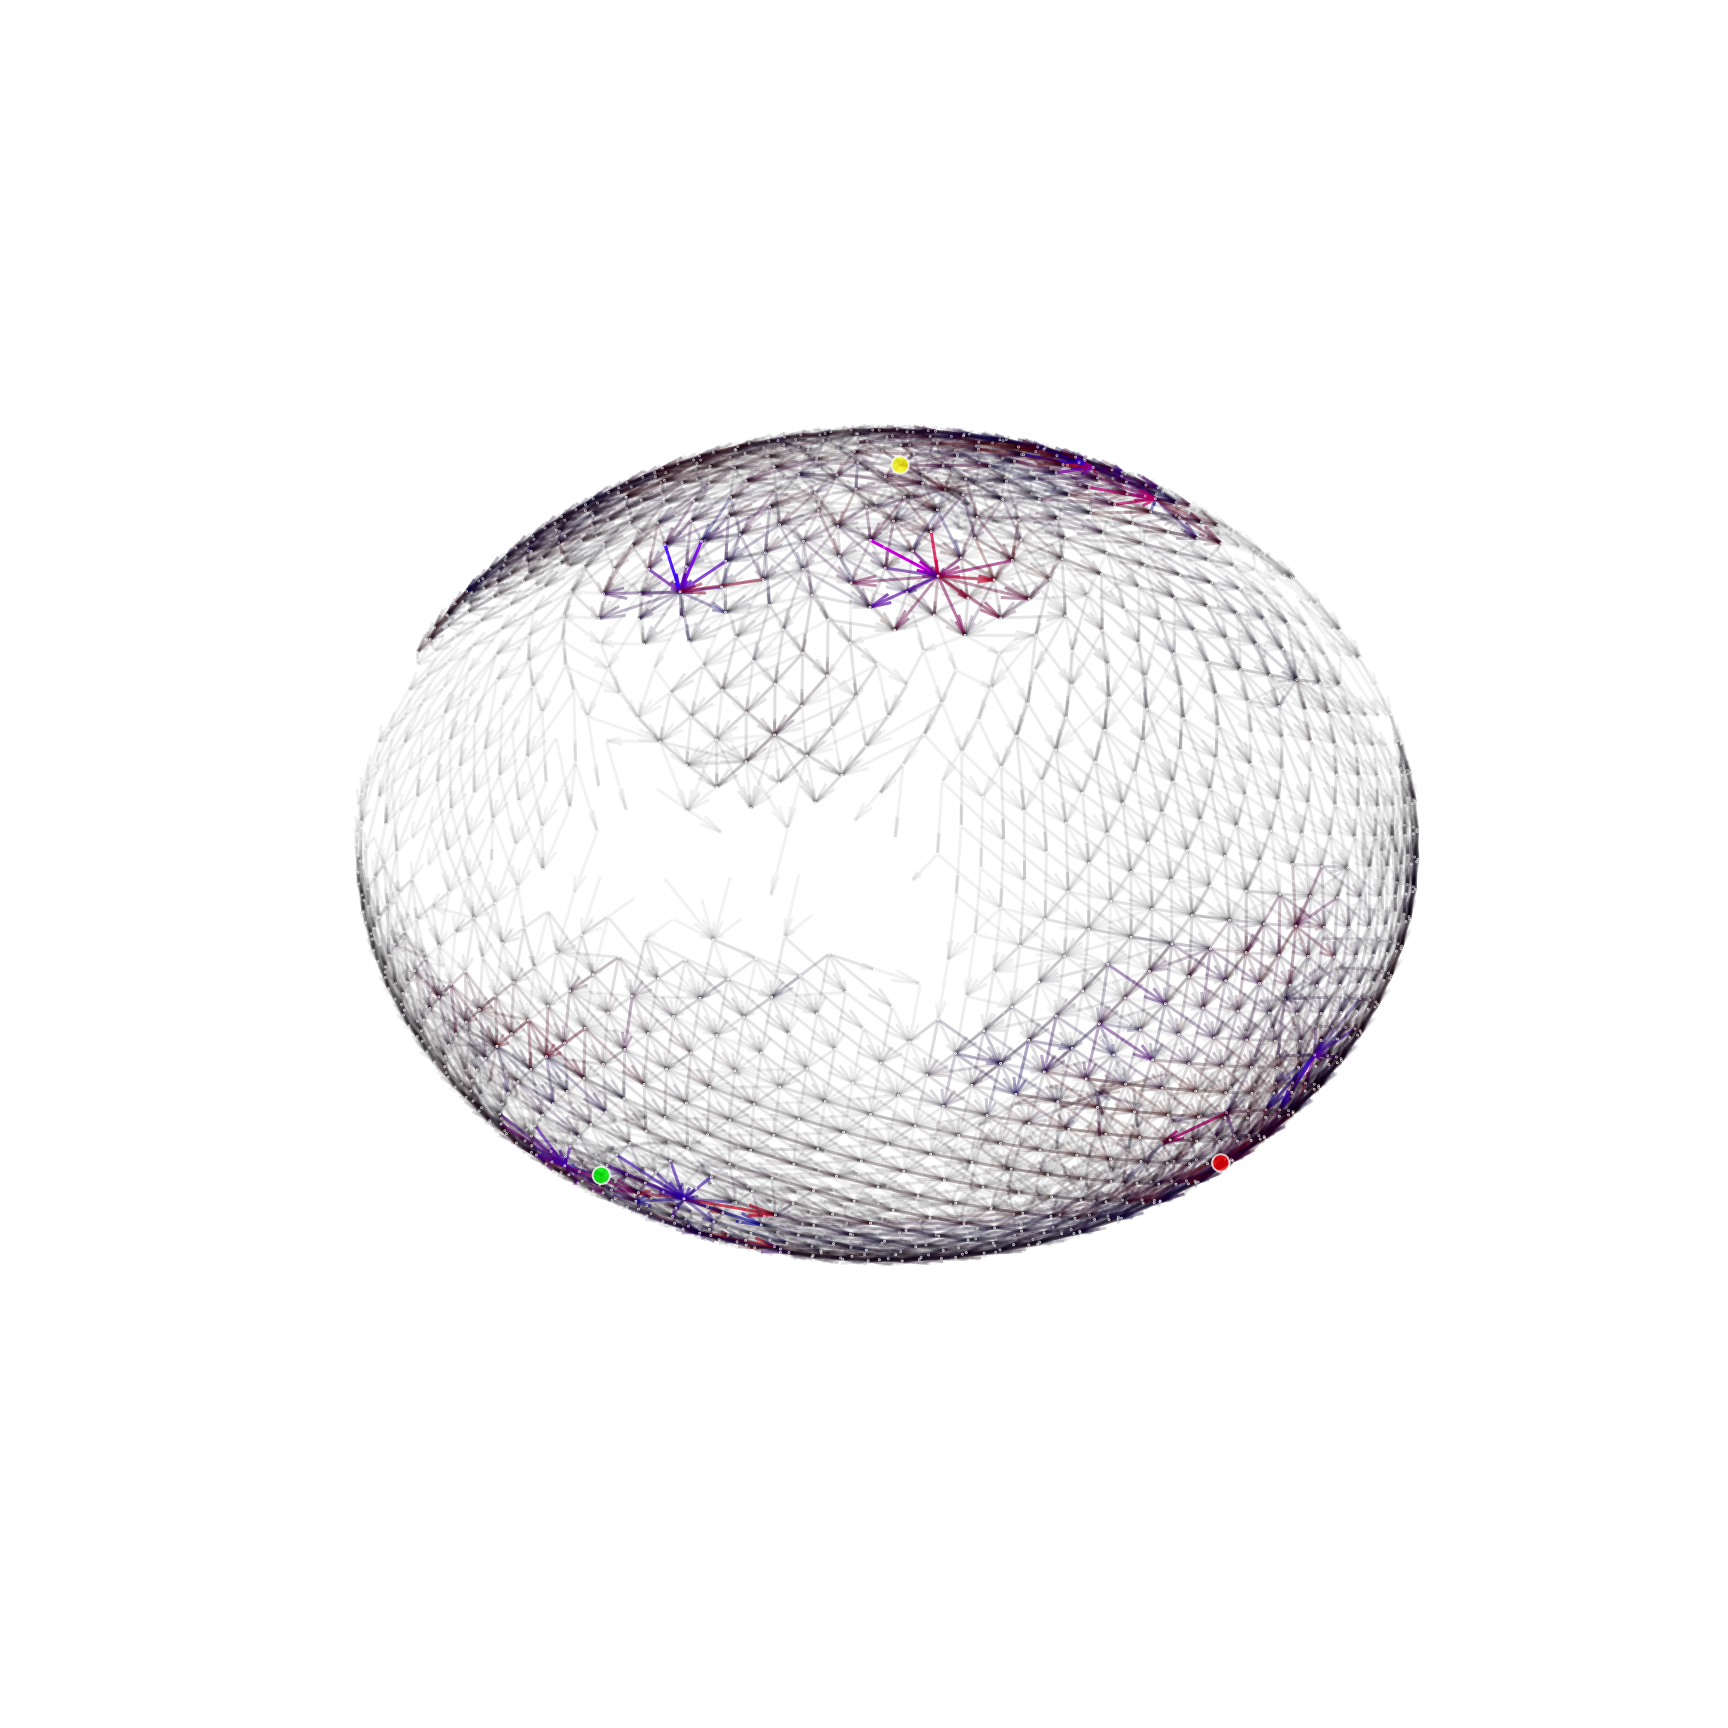

/tmp/ipykernel_80955/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [31]:
%matplotlib notebook
node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]
mJ_ = np.max(np.abs(J_))

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = np.abs(J_[:,0])/mJ_
edge_color[mask,2] = np.abs(J_[:,1])/mJ_
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()

# Plot optimal phi

In [32]:
node_color_ = phi.reshape((CG.number_of_nodes(), d))

<IPython.core.display.Javascript object>


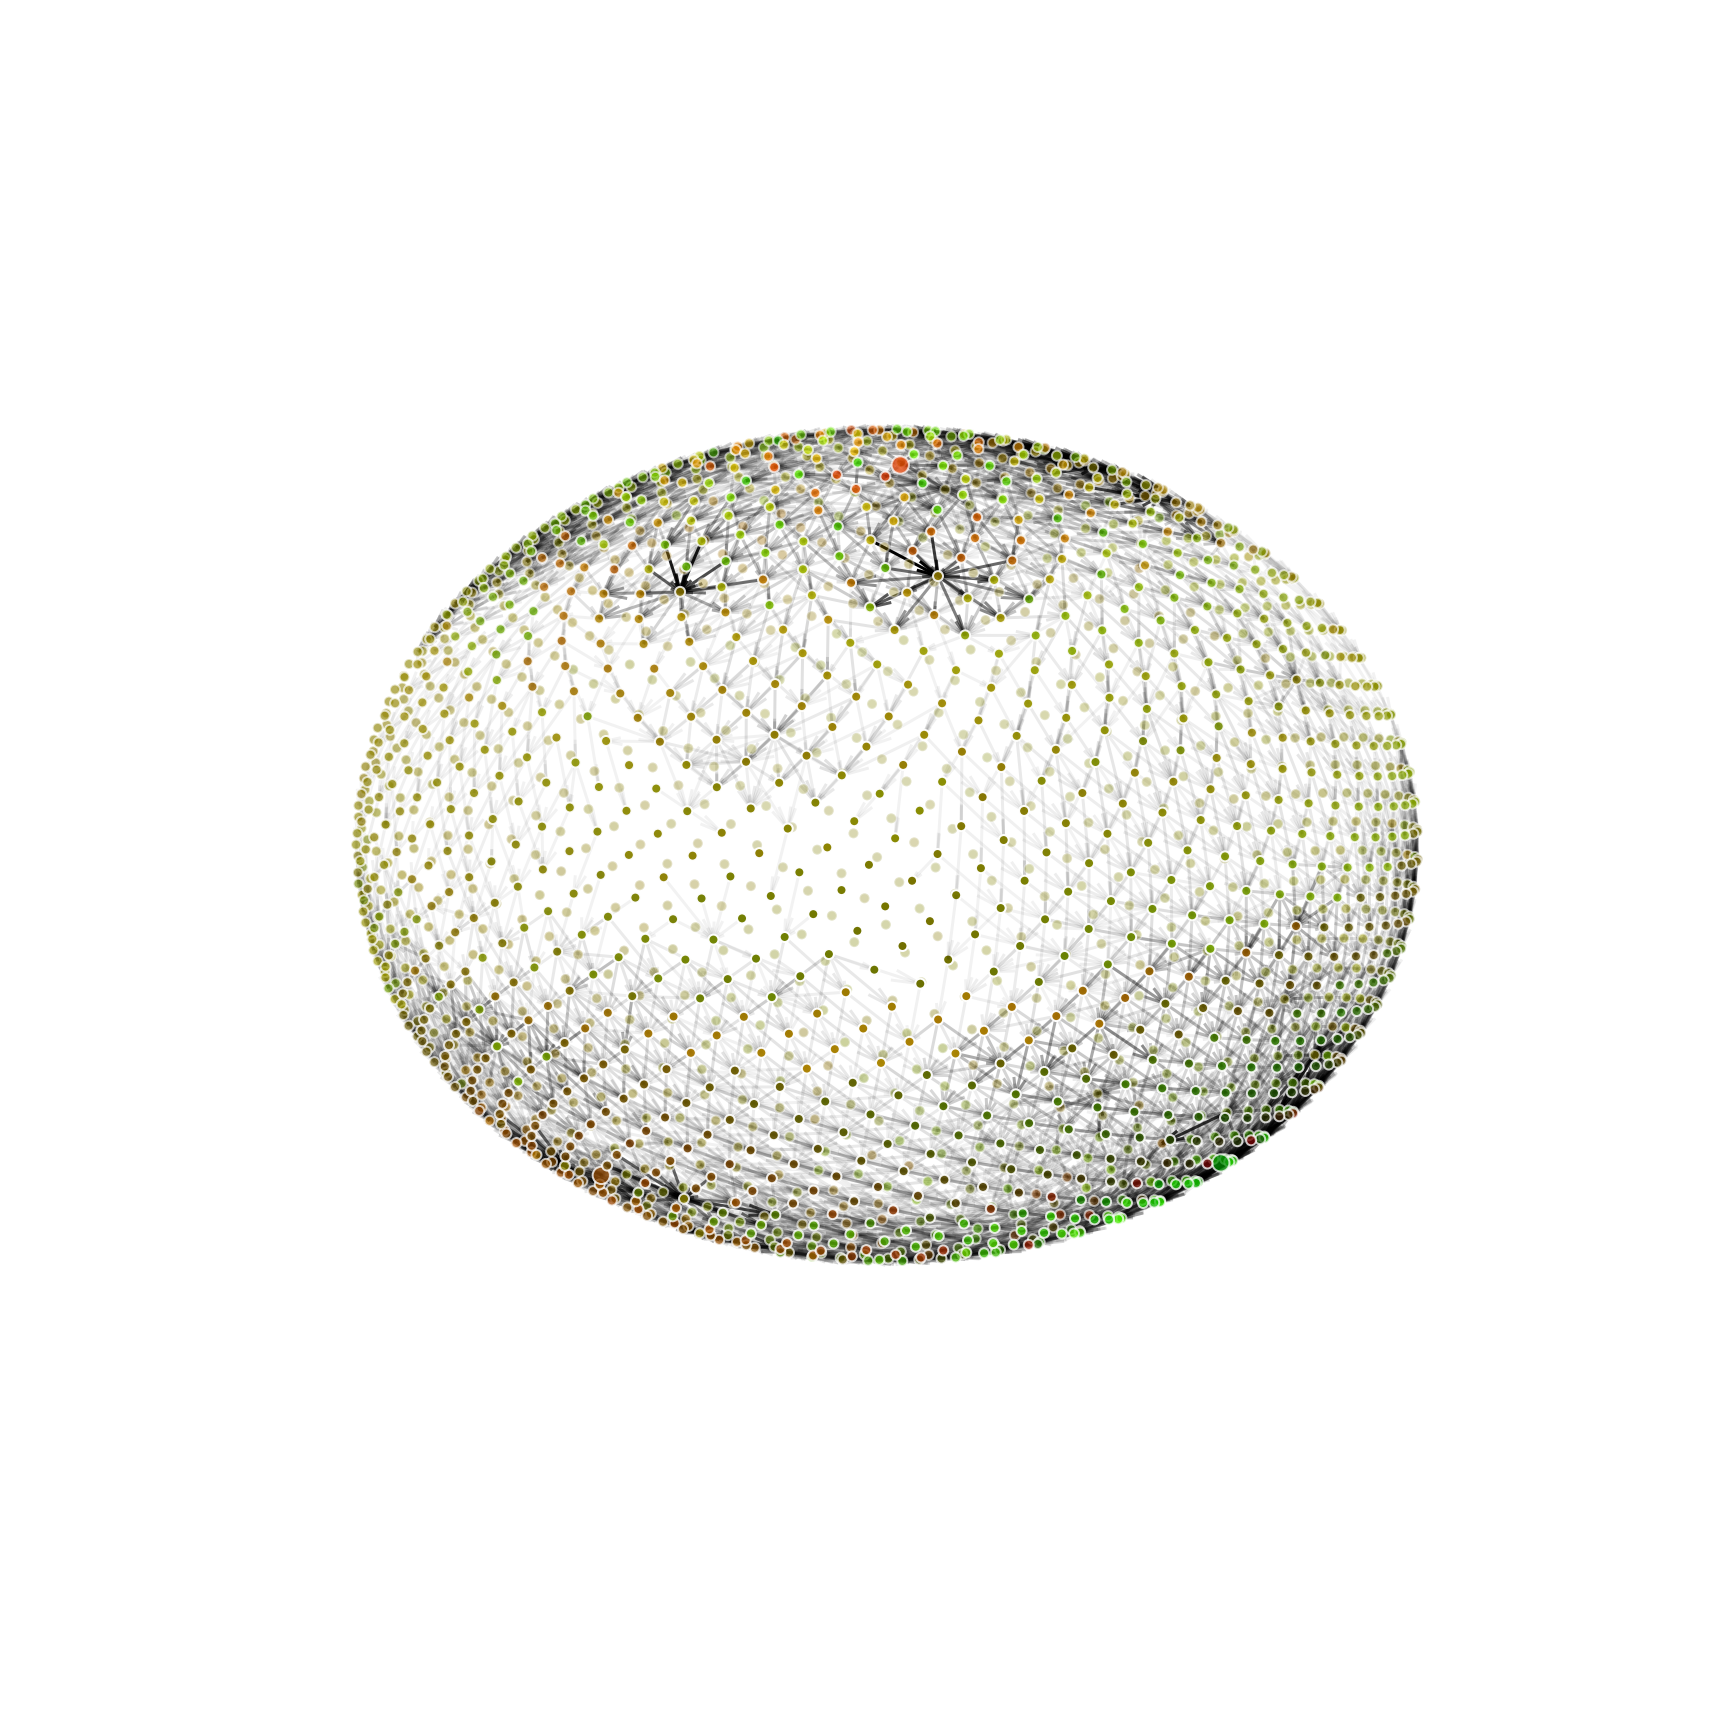

/tmp/ipykernel_80955/1841123288.py:32: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [33]:
%matplotlib notebook
node_size = np.ones(n)*100
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,-1] = 1
node_color[:,0] = (node_color_[:,0] - np.min(node_color_[:,0]))/np.ptp(node_color_[:,0])
node_color[:,1] = (node_color_[:,1] - np.min(node_color_[:,1]))/np.ptp(node_color_[:,1])

mask = (edge_score > 0)

edge_color = np.zeros((edge_score.shape[0],4))
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=0.025, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()